In [1]:
import os
import sys
sys.path.append(os.path.join(os.getcwd().replace("model_inference", "")))

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.profiler import profiler
import matplotlib.pyplot as plt
import time
from parse_dataset import NetworkDataset, parse_dataset, split_datasets
from model import Model
from load_models import models

In [2]:
conf = {
    "batch_size": 512,
    "epochs": 10,
    "learning_rate": 0.0001
}

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [4]:
# extract dataset from csv file
network_data_file = os.path.join(os.getcwd().replace("model_inference", ""), "datasets", "network_packet_data_test.csv")
data, labels, label_dict = parse_dataset(network_data_file)

# split dataset into train, val and test datasets
X_train, y_train, X_val, y_val, X_test, y_test = split_datasets(data, labels)
print(X_train.shape)
print(y_train.shape)

# create train, val and test dataloaders
train_dataset = NetworkDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=conf["batch_size"], shuffle=True)

val_dataset = NetworkDataset(X_val, y_val)
val_loader = DataLoader(val_dataset, batch_size=conf["batch_size"], shuffle=True)

test_dataset = NetworkDataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=conf["batch_size"])

packet_dat,attack_cat

torch.Size([356334, 513])
torch.Size([356334])


In [5]:
X_test2 = X_test.unsqueeze(-1)
print(X_test2.shape)
print(y_test.shape)

test_dataset2 = NetworkDataset(X_test2, y_test)
test_loader2 = DataLoader(test_dataset2, batch_size=conf["batch_size"])

torch.Size([101811, 513, 1])
torch.Size([101811])


In [6]:
class Benchmark:
    def __init__(self, model, model_path):
        self.model = model
        self.model.load(model_path)
    
    def run(self, loader):
        """Run benchmark measuring model accuracy, cpu time, memory usage and total runtime"""
        self.model.model.eval()

        # warm-up before profiling:
        for i in range(5):
            with torch.no_grad():
                data, labels = next(iter(loader))
                pred = self.model.model(data)

        with torch.profiler.profile(
                    activities=[profiler.ProfilerActivity.CPU],
                    record_shapes=True,
                    profile_memory=True,
                    with_stack=True
                ) as prof:
                    data, labels = next(iter(loader))
                    start = time.perf_counter()
                    # warm-up before profiling:
                    with torch.no_grad():
                        pred = self.model.model(data)
                    end = time.perf_counter()
        accuracy = (pred.argmax(dim=1) == labels).float().mean()

        # Wall-clock time
        wall_clock_time = end - start

        # CPU compute time (µs → s)
        cpu_time_total_s = sum([e.self_cpu_time_total for e in prof.key_averages()]) / 1e6  # microseconds
        cpu_utilization = cpu_time_total_s / wall_clock_time

        # peak memory during profiling
        peak_mem = max([e.cpu_memory_usage for e in prof.key_averages()])
        peak_mem = peak_mem / 1024**2 #MB

        return 100*accuracy, cpu_utilization, peak_mem, wall_clock_time

In [7]:
performance ={
    "acc": [],
    "cpu": [],
    "mem": [],
    "time": []

}

model_id = {}

i = 0
for model_name in models.keys():
    model_id[model_name] = i
    i += 1

    model = models[model_name]
    file = model_name + "_model.pth"
    path = os.path.join(os.getcwd().replace("model_inference", ""), "checkpoint", file)
    benchmark = Benchmark(model, path)

    loader = test_loader2
    if model_name == "mlp" or model_name == "light_mlp":
        loader = test_loader
    
    acc, cpu, mem, runtime = benchmark.run(loader=loader)
    performance["acc"].append(acc)
    performance["cpu"].append(cpu)
    performance["mem"].append(mem)
    performance["time"].append(runtime)
    
    print(f"Benchmark ({model_name}): Accuracy: {acc:.2f}%, CPU Usage: {cpu:.2f} cores, Memory Usage: {mem:.2f}MB, Runtime: {runtime:.2f}s")


Checkpoint loaded from /home/jorgetf/testmodel/Network-Packet-ML-Model/checkpoint/mlp_model.pth!


[W926 12:46:39.086627959 CPUAllocator.cpp:245] Memory block of unknown size was allocated before the profiling started, profiler results will not include the deallocation event
ERROR:2025-09-26 12:46:39 3322838:3322838 DeviceProperties.cpp:47] gpuGetDeviceCount failed with code 35


Benchmark (mlp): Accuracy: 83.59%, CPU Usage: 43.21 cores, Memory Usage: 1.01MB, Runtime: 0.00s
Checkpoint loaded from /home/jorgetf/testmodel/Network-Packet-ML-Model/checkpoint/light_mlp_model.pth!
Benchmark (light_mlp): Accuracy: 75.98%, CPU Usage: 16.82 cores, Memory Usage: 1.01MB, Runtime: 0.00s
Checkpoint loaded from /home/jorgetf/testmodel/Network-Packet-ML-Model/checkpoint/lstm_model.pth!
Benchmark (lstm): Accuracy: 96.88%, CPU Usage: 1.02 cores, Memory Usage: 518.50MB, Runtime: 0.54s
Checkpoint loaded from /home/jorgetf/testmodel/Network-Packet-ML-Model/checkpoint/light_lstm_model.pth!
Benchmark (light_lstm): Accuracy: 91.21%, CPU Usage: 1.27 cores, Memory Usage: 65.82MB, Runtime: 0.03s
Checkpoint loaded from /home/jorgetf/testmodel/Network-Packet-ML-Model/checkpoint/gru_model.pth!
Benchmark (gru): Accuracy: 97.07%, CPU Usage: 1.00 cores, Memory Usage: 3078.30MB, Runtime: 2.95s
Checkpoint loaded from /home/jorgetf/testmodel/Network-Packet-ML-Model/checkpoint/light_gru_model.pth

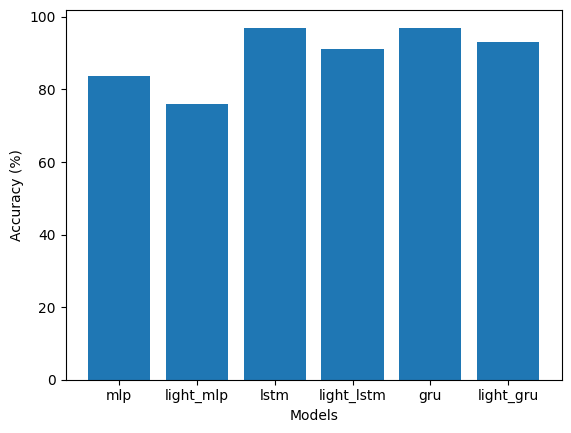

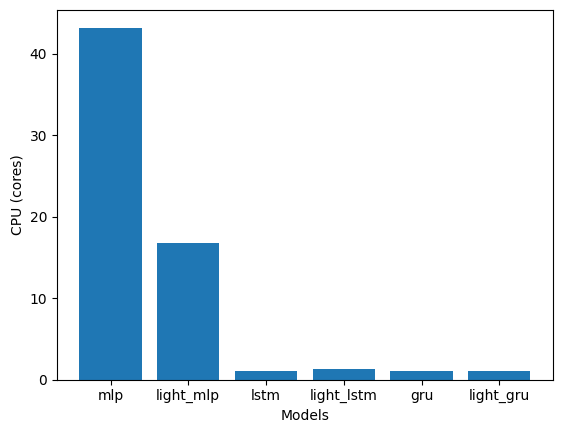

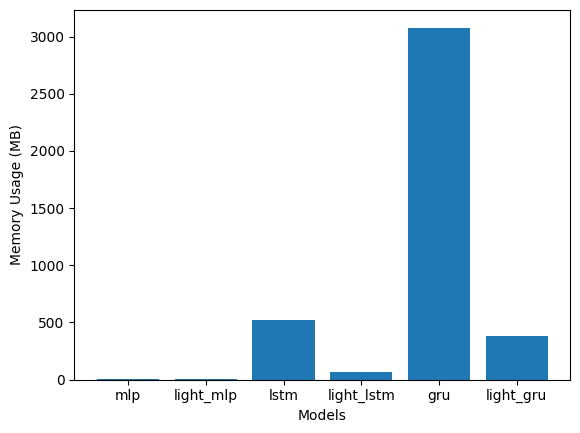

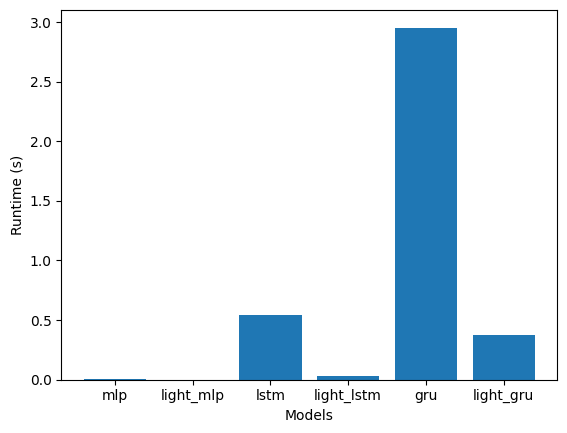

In [8]:
model_names = list(model_id.keys())

for data_type in performance.keys():
    plt.bar(model_names, performance[data_type])
    plt.xlabel("Models")
    y_value = ""
    if data_type == "acc":
        y_value = "Accuracy (%)"
    elif data_type == "cpu":
        y_value = "CPU (cores)"
    elif data_type == "mem":
        y_value = "Memory Usage (MB)"
    else:
        y_value = "Runtime (s)"
    
    plt.ylabel(y_value)
    plt.show()